In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.preprocessing import PowerTransformer, StandardScaler, RobustScaler
from tqdm import tqdm
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import json, copy, pickle, torch, warnings, datetime
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore")

## Model

In [2]:
df = pd.read_csv("data/inverse/FG.csv", parse_dates = ["date"])

print("shape:", df.shape)
print(f'''\ntrain counts of 1 & 0:\n{df.query("sample == 'train'")['sar_flag'].value_counts()}''')
print(f'''\ntest counts of 1 & 0:\n{df.query("sample == 'test'")['sar_flag'].value_counts()}''')
df.head(3)

shape: (9716, 189)

train counts of 1 & 0:
0.0    7466
1.0     245
Name: sar_flag, dtype: int64

test counts of 1 & 0:
Series([], Name: sar_flag, dtype: int64)


,sample,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,total_asset_pct,...,dp_db_sum_1m,dp_db_max_median_1m,dp_cr_ct_1m,dp_cr_min_1m,dp_cr_max_1m,dp_cr_mean_1m,dp_cr_median_1m,dp_cr_sum_1m,dp_cr_min_median_1m,period
0,train,171320,2021-04-01,0.0,14,1,12.0,1038.0,6,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,train,171357,2021-04-01,0.0,16,1,19.0,104.0,5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,train,171362,2021-04-01,0.0,18,1,13.0,462187.0,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### Features

In [3]:
target = "sar_flag"
cat_feats = ['risk_rank', 'occupation_code', 'AGE']
othet_feats = ['alert_key', 'date', 'cust_id']
time = "period"
alert_key = "alert_key"

In [4]:
num_feats = list(set(df.columns) - set([target]) - set(cat_feats) - set(othet_feats) - set(["sample"]))
print(len(num_feats) + len(cat_feats) + len(othet_feats) + 1)

188


### Missing value

In [5]:
df[num_feats] = df[num_feats].fillna(0)

In [6]:
# 職業為missing value的樣本有116個，占比不高，都在train data，且sar_flag皆為0，刪除
occu_null = df["occupation_code"].isnull()
print(f"{occu_null.sum()} / {len(df)} = {round(occu_null.sum() / len(df), 5)}")
print("sar_flag次數:", df[occu_null]["sar_flag"].sum())
df = df[~occu_null].reset_index(drop = True)

50 / 9716 = 0.00515
sar_flag次數: 0.0


### Label encoding

In [7]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
for feat in cat_feats:
    df[feat] = le.fit_transform(df[feat])

### Split Train & Test

In [8]:
train = df.query("sample == 'train'").copy()
test = df.query("sample == 'test'").copy()

print(f"train: {len(train)}, test: {len(test)}")

train: 7661, test: 2005


### 刪除變數數值超過變數在sar_flag = 1的最大/小值之樣本

num_feats1 = ["dp_ct_1w", "cdtx_ct_1w", "remit_ct_1w"]
des1 = test[test[target] == 1][num_feats].describe()
des1 = des1.loc[["min", "max"]]
des1 = des1[num_feats1]#, "dp_db_max_1w", "dp_cr_min_1w"
des1 = des1.to_dict()
des1

drop_index = []
print(f"init: {len(train)}")
for feat in num_feats1:
    drop_idx = train[(train[feat] < des1[feat]["min"]) | (train[feat] >  des1[feat]["max"])].index
    drop_index.extend(drop_idx)
drop_index = set(drop_index)
print(f"drop: {len(drop_index)}")

train.loc[drop_index]["sar_flag"].sum()

train = train.drop(drop_index)

drop_index = []
print(f"init: {len(test)}")
for feat in num_feats1:
    drop_idx = test[(test[feat] < des1[feat]["min"]) | (test[feat] >  des1[feat]["max"])].index
    drop_index.extend(drop_idx)
drop_index = set(drop_index)
print(f"{feat}: {len(drop_index)}")

test.loc[drop_index]["sar_flag"].sum()

test = test.drop(drop_index)

print(f"train: {len(train)}, test: {len(test)}")

train[num_feats] = train[num_feats].fillna(0)
test[num_feats] = test[num_feats].fillna(0)

### Outlier

In [9]:
for feat in num_feats:
    q3 = train[feat].quantile(0.75)
    q1 = train[feat].quantile(0.25)
    iqr = q3 - q1

    max_ = q3 + iqr
    min_ = q1 + iqr
    
    train[feat] = train[feat].apply(lambda X: max_ if X > max_ else X)
    train[feat] = train[feat].apply(lambda X: min_ if X < min_ else X)

    test[feat] = test[feat].apply(lambda X: max_ if X > max_ else X)
    test[feat] = test[feat].apply(lambda X: min_ if X < min_ else X)

### Qusi-constant feature

In [10]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold = 0.05)
selector.fit(train[num_feats])
selector.get_support()
drop_feats = [feat for feat, keep in zip(num_feats, selector.get_support()) if not keep]

train = train.drop(drop_feats, axis = 1)
test = test.drop(drop_feats, axis = 1)

num_feats = [feat for feat, keep in zip(num_feats, selector.get_support()) if keep]
len(drop_feats)

89

### Adversarial

import xgboost as xgb
from xgboost import XGBClassifier, plot_importance, cv

def adversarial(train, test):
    # add train, test label
    train["AV"] = 0
    test["AV"] = 1

    # merge train, test
    df1 = pd.concat([train, test], ignore_index = True)

    # shuffle data
    df1_shuffled = df1.sample(frac=1)

    # create XGBoost data structure
    X = df1_shuffled.drop(['AV'], axis=1)
    y = df1_shuffled['AV']
    XGBdata = xgb.DMatrix(data = X, label = y)

    # XGBoost parameters
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        'learning_rate': 0.05,
        'max_depth': 5
        }

    # perform cross validation with XGBoost
    cross_val_results = cv(
        dtrain = XGBdata,
        params = params, 
        nfold = 5,
        metrics = "auc", 
        num_boost_round = 200,
        early_stopping_rounds = 20,
        as_pandas = True
        )

    # final result
    print("Accuracy:", cross_val_results["test-auc-mean"].iloc[-1])


    classifier = XGBClassifier(eval_metric = 'logloss', use_label_encoder = False)
    classifier.fit(X, y)
    fig, ax = plt.subplots(figsize=(10, 7))
    plot_importance(classifier, ax=ax, max_num_features = 80, height  = 0.5)
    plt.show()

    return classifier, [i.get_text() for i in ax.axes.get_yticklabels()]

drop_feat = ["sar_flag", "sample", "date", "alert_key", 'cust_id']

train1 = train.drop(drop_feat, axis = 1)
test1 = test.drop(drop_feat, axis = 1)

#adversarial validation
classifier, drop_feat1 = adversarial(train1, test1)


drop_feat = drop_feat + drop_feat1
train1 = train.drop(drop_feat, axis = 1)
test1 = test.drop(drop_feat, axis = 1)

#adversarial validation
classifier, drop_feat2 = adversarial(train1, test1)

train = train.drop(drop_feat1, axis = 1)
test = test.drop(drop_feat1, axis = 1)
print(train.shape, test.shape)

num_feats = [i for i in num_feats if i not in drop_feat1]

### Skew

from scipy.stats import skew

skewness = train[num_feats].apply(lambda X: skew(X)).sort_values(ascending=False)
skewness = pd.DataFrame({'Feature' : skewness.index, 'Skew' : skewness.values})
skewness = skewness.query("(Skew > 0.75) | (Skew < -0.75)")
skewness = skewness.reset_index(drop = True)
skewness

from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method = 'yeo-johnson')
train[skewness["Feature"]] = pt.fit_transform(train[skewness["Feature"]])
test[skewness["Feature"]] = pt.transform(test[skewness["Feature"]])

from scipy.stats import skew

skewness = train[num_feats].apply(lambda X: skew(X)).sort_values(ascending=False)
skewness = pd.DataFrame({'Feature' : skewness.index, 'Skew' : skewness.values})
skewness = skewness.query("(Skew > 0.75) | (Skew < -0.75)")
skewness = skewness.reset_index(drop = True)
skewness

### Scaling

In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
scaler = MinMaxScaler()
train[num_feats] = scaler.fit_transform(train[num_feats])
test[num_feats] = scaler.transform(test[num_feats])
train.head()

,sample,alert_key,date,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE,info_ct,...,dp_db_sum_1m,dp_db_max_median_1m,dp_cr_ct_1m,dp_cr_min_1m,dp_cr_max_1m,dp_cr_mean_1m,dp_cr_median_1m,dp_cr_sum_1m,dp_cr_min_median_1m,period
0,train,171320,2021-04-01,0.0,14,1,12,0.0,6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,train,171357,2021-04-01,0.0,16,1,19,0.0,5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,train,171362,2021-04-01,0.0,18,1,13,0.0,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,train,171363,2021-04-01,0.0,19,1,9,1.0,6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,train,171375,2021-04-01,0.0,25,1,9,1.0,6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split train、valid

In [12]:
from sklearn.model_selection import train_test_split

train_data, valid_data = train_test_split(train, test_size = 0.3, random_state = 99, stratify = train[target])
test_data = test.copy()
print(train_data.shape, valid_data.shape, test_data.shape)

(5362, 100) (2299, 100) (2005, 100)


In [13]:
print("4886 / 164 = ", round(4886 / 164, 3))
train_data.loc[train_data["alert_key"].drop_duplicates().index]["sar_flag"].value_counts()

4886 / 164 =  29.793


0.0    5191
1.0     171
Name: sar_flag, dtype: int64

In [14]:
print("2095 / 70 = ", round(2095 / 70, 3))
valid_data.loc[valid_data["alert_key"].drop_duplicates().index]["sar_flag"].value_counts()

2095 / 70 =  29.929


0.0    2225
1.0      74
Name: sar_flag, dtype: int64

In [15]:
print("1835 / 10 = ", round(1835 / 10, 3))
test_data.loc[test_data["alert_key"].drop_duplicates().index]["sar_flag"].value_counts()

1835 / 10 =  183.5


Series([], Name: sar_flag, dtype: int64)

### DataFrame transform to Torch Dataset

In [16]:
class Dataset_transform(Dataset):
    def __init__(self, df, features, target, alert_key):
        self.n_samples = len(df)
        self.X = torch.Tensor(df[features].values)#.to(device)
        self.y = torch.Tensor(df[target].values.reshape(-1, 1))#.to(device)
        self.alert_key = torch.Tensor(df[alert_key].values.reshape(-1, 1)).long()#.to(device)
                                            
    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        return self.X[index], self.y[index], self.alert_key[index]

In [17]:
features = num_feats + cat_feats

In [18]:
train_dataset = Dataset_transform(train_data, features, target, alert_key)
valid_dataset = Dataset_transform(valid_data, features, target, alert_key)
test_dataset = Dataset_transform(test_data, features, target, alert_key)

In [19]:
train_dataset.__getitem__(3)

(tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,
          0.0000,  0.6667,  0.2500,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.0000,  0.4545,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.7368,  1.0000,  0.3333,
          0.0000,  0.5000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.7418,  1.0000,  1.0000,
          0.0000,  0.7665,  0.0000,  1.0000,  0.1667,  1.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.7500,  0.0000,  0.0000,  0.9635,  0.0000,  0.6667,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.4545,
          0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  1.0000,  0.0000,  3.0000, 17.0000,  4.0000]),
 tensor([0.]),
 tensor([305694]))

### DataLoader for batch

In [20]:
batch_size = 128
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size)#, batch_size = len(valid_dataset))
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)#, batch_size = len(test_dataset))

### Embedding structure

In [21]:
cat_feats_num = df[cat_feats].nunique()
cat_feats_num = pd.DataFrame(cat_feats_num, columns = ["input"])
cat_feats_num["output"] = np.ceil(cat_feats_num ** (0.25)).astype(int)
cat_feats_num = cat_feats_num.T.to_dict()
cat_feats_num

{'risk_rank': {'input': 4, 'output': 2},
 'occupation_code': {'input': 21, 'output': 3},
 'AGE': {'input': 11, 'output': 2}}

In [22]:
class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [nn.Embedding(v["input"], v["output"]) for v in cat_feats_num.values()]
        self.embeddings = torch.nn.ModuleList(layers)
    
    def forward(self, x):
        num_x = x[:, :-len(cat_feats_num)]
        cat_x = x[:, -len(cat_feats_num):]

        emb_x = []
        for i, feat_embedder in enumerate(self.embeddings):
            feat_x = feat_embedder(cat_x[:, i].long())
            emb_x.append(feat_x)
            
        emb_x = torch.cat(emb_x, dim=1)# 把所有feature的向量合併
        new_x = torch.cat((num_x, emb_x), dim = 1)

        return new_x

### Model structure

In [23]:
class Model(nn.Module):
    def __init__(self, input_size, embedder):
        super().__init__()
        self.embedder = embedder

        self.net  = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.embedder(x)
        x = self.net(x)
        return x

### Initialize model

In [24]:
epochs = 500
input_size = len(features) - len(cat_feats) + sum([v["output"] for v in cat_feats_num.values()])

embedder = Embedder()

model = Model(input_size, embedder)#.to(device)
criterion = nn.BCELoss()#.to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

### Initialize weights

In [25]:
#初始化權重，使其符合常態分布
for m in model.modules():
    if isinstance(m, (nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Embedding):
        nn.init.kaiming_normal_(m.weight)

### Weight of loss function

In [26]:
pos = len(train[target]) / (train[target].sum())
neg = len(train[target]) / (len(train[target]) - (train[target].sum()))
# pos = 1; neg = 1
pos, neg

(31.26938775510204, 1.0330366774541533)

In [27]:
def loss_weight(labels, pos, neg):
    weight = []
    for label in labels:
        if label == 1:
            weight.append(pos)
        elif label == 0:
            weight.append(neg)
            
    return torch.tensor(weight).reshape(-1, 1)

### Training model

In [28]:
def model_train(dataloader, model, criterion, _tqdm):
    model.train() # 模型為訓練模式
    losses = 0
    for  batch, (X, y, alert) in enumerate(dataloader):
        pred = model(X) #預測

        weight = loss_weight(y, pos, neg)
        criterion = nn.BCELoss(weight = weight)
        loss = criterion(pred, y) #計算損失函數
        losses += loss.item()
        
        optimizer.zero_grad() # 梯度在反向傳播前先清零
        loss.backward() # 反向傳播，計算權重對損失函數的梯度
        optimizer.step()  # 根據梯度更新權重

        _tqdm.set_postfix({"train_loss" : loss.item()})
        _tqdm.update(1)

    losses /= (batch + 1)

    return model, losses

In [29]:
def model_eval(dataloader, model, criterion, mode = "train"):
    model.eval() # 模型為訓練模式
    preds, ys, alerts = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])
    with torch.no_grad():
        losses = 0
        for  batch, (X, y, alert) in enumerate(dataloader):
            pred = model(X) #預測

            if mode != "test":
                weight = loss_weight(y, pos, neg)
                criterion = nn.BCELoss(weight = weight)
                loss = criterion(pred, y) #計算損失函數
                losses += loss.item()

            preds = torch.concat([preds, pred])
            ys = torch.concat([ys, y])
            alerts = torch.concat([alerts, alert])

        if mode != "test":
            losses /= (batch + 1)

            return losses
        
        return preds, ys, alerts

In [30]:
# 建模
best_loss = np.inf
paitence = 5
remain_patience = 0
train_losses = []
valid_losses = []
for epoch in range(epochs):

    with tqdm(total = len(train_dataloader), ncols = 180) as _tqdm: # 使用需要的參數對tqdm進行初始化
        _tqdm.set_description('epoch: {}/{}'.format(epoch + 1, epochs))# 設置前綴 一般為epoch的信息
        
        # train model
        model, train_loss = model_train(train_dataloader, model, criterion, _tqdm)
        train_losses.append(train_loss)

        # validate model
        valid_loss = model_eval(valid_dataloader, model, criterion, mode = "train")
        valid_losses.append(valid_loss)

        # 損失函數連續30個epoches都沒下降的話就終止訓練
        if valid_loss < best_loss:
            best_loss = valid_loss
            remain_patience = paitence
            _tqdm.set_postfix({"train_loss" : train_loss, "valid_loss": valid_loss, "best_loss": best_loss})# 設置想在本次循環監視變量，可作後綴打印出來
        else:
            _tqdm.set_postfix({"train_loss" : train_loss, "valid_loss": valid_loss, "best_loss": best_loss})# 設置想在本次循環監視變量，可作後綴打印出來
            remain_patience -= 1
            if remain_patience == 0:
                print('early stop!')
                break
        
print("Done!")

epoch: 98/500: 100%|██████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 113.18it/s, train_loss=0.886, valid_loss=0.696, best_loss=0.693]

early stop!
Done!


Text(0, 0.5, 'loss')

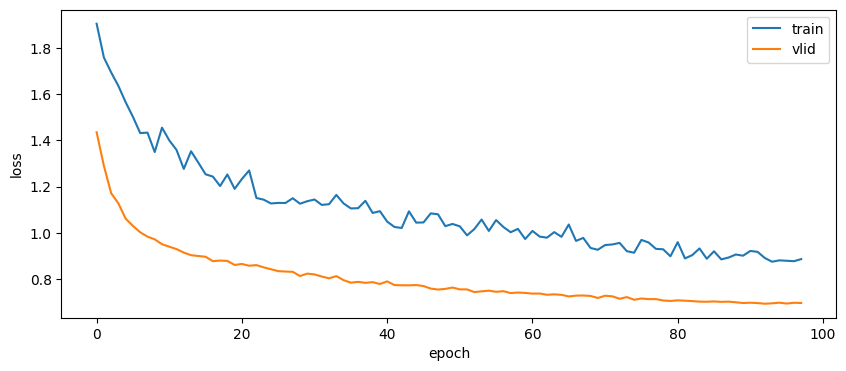

In [31]:
plt.figure(figsize = (10, 4))
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(["train", "vlid"])
plt.xlabel("epoch")
plt.ylabel("loss")

### Predict

In [32]:
train_pred, train_y, train_alert = model_eval(train_dataloader, model, criterion, mode = "test")
valid_pred, valid_y, valid_alert = model_eval(valid_dataloader, model, criterion, mode = "test")
test_pred, test_y, test_alert = model_eval(test_dataloader, model, criterion, mode = "test")

In [33]:
train_result = torch.concat((train_alert, train_pred, train_y), dim = 1)
train_result = pd.DataFrame(train_result, columns = ["alert_key", "probability", "sar_flag"])

valid_result = torch.concat((valid_alert, valid_pred, valid_y), dim = 1)
valid_result = pd.DataFrame(valid_result, columns = ["alert_key", "probability", "sar_flag"])

test_result = torch.concat((test_alert, test_pred, test_y), dim = 1)
test_result = pd.DataFrame(test_result, columns = ["alert_key", "probability", "sar_flag"])
test_result.head()

,alert_key,probability,sar_flag
0,365126.0,0.578901,NaN
1,365163.0,0.098110,NaN
2,365166.0,0.245101,NaN
3,365167.0,0.232864,NaN
4,365168.0,0.077038,NaN


In [34]:
train_result = train_result.sort_values("probability", ascending = False).reset_index(drop = True)
valid_result = valid_result.sort_values("probability", ascending = False).reset_index(drop = True)
test_result = test_result.sort_values("probability", ascending = False).reset_index(drop = True)

### Recall N-1 score

In [35]:
train_sar = int(train_result[target].sum())
train_len = train_result[train_result[target] == 1].index[-2] + 1
print(f"train total: {len(train_result)}")
print(f"({train_sar} - 1) / {train_len} = {(train_sar - 1) / train_len}\n")

valid_sar = int(valid_result[target].sum())
valid_len = valid_result[valid_result[target] == 1].index[-2] + 1
print(f"Valid total: {len(valid_result)}")
print(f"({valid_sar} - 1) / {valid_len} = {(valid_sar - 1) / valid_len}\n")

# test_sar = int(test_result[target].sum())
# test_len = test_result[test_result[target] == 1].index[-2] + 1
# print(f"Test total: {len(test_result)}")
# print(f"({test_sar} - 1) / {test_len} = {(test_sar - 1) / test_len}")

train total: 5362
(171 - 1) / 3279 = 0.0518450747179018

Valid total: 2299
(74 - 1) / 907 = 0.0804851157662624



In [36]:
public = pd.read_csv("data/submit/1217_1.csv")

result = pd.concat([train_result, valid_result, test_result], ignore_index = True)
result = result.drop(target, axis = 1)
result["alert_key"] = result["alert_key"].astype(int)

result = pd.merge(public["alert_key"], result, on = ["alert_key"], how = "left")

result["probability"] = result["probability"].fillna(0)

result.to_csv("data/submit/1226.csv", index = False)
result

,alert_key,probability
0,356602,0.866303
1,355724,0.944693
2,358453,0.931213
3,361617,0.885478
4,359668,0.900306
...,...,...
3845,371792,0.170550
3846,373453,0.754557
3847,375469,0.208148
3848,369969,0.702704


### sar probability distribution

In [37]:
test_result[test_result[target] == 1]

,alert_key,probability,sar_flag


In [38]:
test_result[test_result[target] == 0]

,alert_key,probability,sar_flag


In [39]:
valid_result[valid_result[target] == 1]

,alert_key,probability,sar_flag
3,218840.0,0.976447,1.0
4,248256.0,0.975110,1.0
5,194991.0,0.973416,1.0
7,215933.0,0.970203,1.0
8,203149.0,0.969693,1.0
...,...,...,...
543,196191.0,0.439615,1.0
762,279637.0,0.303999,1.0
902,363033.0,0.242923,1.0
906,214426.0,0.240642,1.0


In [40]:
train_result[train_result[target] == 1]

,alert_key,probability,sar_flag
1,193308.0,0.980247,1.0
2,204193.0,0.978836,1.0
3,192503.0,0.977519,1.0
4,230638.0,0.975971,1.0
5,189123.0,0.975826,1.0
...,...,...,...
1802,244115.0,0.283004,1.0
2121,257134.0,0.233491,1.0
2809,303923.0,0.179979,1.0
3278,171770.0,0.149625,1.0


## ML

X_train = train[features]
y_train = train[target]

X_valid = test[features]
y_valid = test[target]

### Resample

from imblearn.over_sampling import SMOTE, ADASYN
oversample = SMOTE(random_state=99)
X_train, y_train = oversample.fit_resample(X_train, y_train)
y_train.value_counts()

### Target encoding

import category_encoders as ce

ce_target = ce.TargetEncoder(cols = cat_feats)
X_train = ce_target.fit_transform(X_train, y_train)
X_valid = ce_target.transform(X_valid)

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier, BalancedBaggingClassifier, RUSBoostClassifier


random_state = 99#None
models = {
    "Logistic": LogisticRegression(),
    "Bayes (Gaussian)": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    # "SVC": SVC(probability = True),
    # "Neural Network": MLPClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state = random_state),
    "Random Forest": RandomForestClassifier(random_state = random_state, class_weight="balanced"),
    "Gradient Boost": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(random_state = random_state),
    "LightGBM": LGBMClassifier(random_state = random_state), # feature name should be number
    # "Cat Boost": CatBoostClassifier(random_state = random_state),
    # "Bayes (Complement)": ComplementNB(), # for imbalance data (X cannot be negative)
    "Easy Ensemble (AdaBoost)":EasyEnsembleClassifier(random_state = random_state),
    "Easy Ensemble (Logistic)":EasyEnsembleClassifier(random_state = random_state, base_estimator = LogisticRegression()),
    # "Easy Ensemble (SVC)":EasyEnsembleClassifier(random_state = random_state, base_estimator = SVC(probability = True)),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, precision_score, f1_score, fbeta_score
from sklearn.model_selection import ShuffleSplit, cross_val_score

#acc_bound = 0.7
#f1w_bound = 0.5

score = []
flag = 1
cv_flag = 0
for key, model in models.items():
    pred_train = model.predict(X_train)
    pred_test  = model.predict(X_valid)

    acc_train  = accuracy_score(y_train, pred_train).round(2)
    acc_test   = accuracy_score(y_valid, pred_test).round(2)

    recall_train  = recall_score(y_train, pred_train).round(2)
    recall_test   = recall_score(y_valid, pred_test).round(2)

    precision_train  = precision_score(y_train, pred_train).round(2)
    precision_test   = precision_score(y_valid, pred_test).round(2)

    f1_train = f1_score(y_train, pred_train).round(2)
    f1_test = f1_score(y_valid, pred_test).round(2)
    
    if flag == 1:
        col1 = [acc_train, acc_test, recall_train, recall_test, precision_train, precision_test, f1_train, f1_test]
        col2 = ["Accuracy_train", "Accuracy_test", "Recall_train", "Recall_test", "Precision_train", "Precision_test", "f1_train", "f1_test"]
    else:
        col1 = [acc_test, recall_test, precision_test, f1_test]
        col2 = ["Accuracy", "Recall", "Precision", "f1"]

    if cv_flag:
        # cv = ShuffleSplit(n_splits = 3, test_size = 0.2)
        cv_scores = cross_val_score(model, X_train, y_train, cv = 3, scoring = 'accuracy')
        cv_score = cv_scores.mean().round(2)
        col1 += [cv_score]
        col2 += ["f1_cv"]

    score.append(col1)
    
    # if (acc_test >= acc_bound) & (f1_test >= f1w_bound):
    col3 = sorted(list(set(y_valid) | set(pred_test)))
    confusion = pd.DataFrame(confusion_matrix(y_valid, pred_test), index = col3, columns = col3)
    confusion["Total"] = confusion.sum(axis = 1)
    confusion.loc["Total"] = confusion.sum(axis = 0)

    
    confusion = confusion.astype(int)
    
    print(f"<< {key.lstrip()} >>")
    print(f"\nConfusion Matrix:\n {confusion}")
    print(f"\nClassification Report:\n{classification_report(y_valid, pred_test)}")
    print("-"*60)
    
index  = [i.lstrip() for i in models.keys()]
score  = pd.DataFrame(score, index = index, columns = col2)
score = score.sort_values(["Recall_test", "Precision_test", "f1_test", "Accuracy_test"], ascending = False)
score

best_model = "Bayes (Gaussian)"
pred_valid  = models[best_model].predict_proba(X_valid)
pred_valid = pred_valid[:, 1]
pred_valid

test_result = test[["alert_key", "sar_flag"]]
test_result["probability"] = pred_valid
test_result = test_result.sort_values("probability", ascending = False).reset_index(drop = True)
test_result

test_sar = int(test_result[target].sum())
test_len = test_result[test_result[target] == 1].index[-2] + 1
print(f"Test total: {len(test_result)}")
print(f"({test_sar} - 1) / {test_len} = {(test_sar - 1) / test_len}")